<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MSN-D2"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/MSN-D2/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


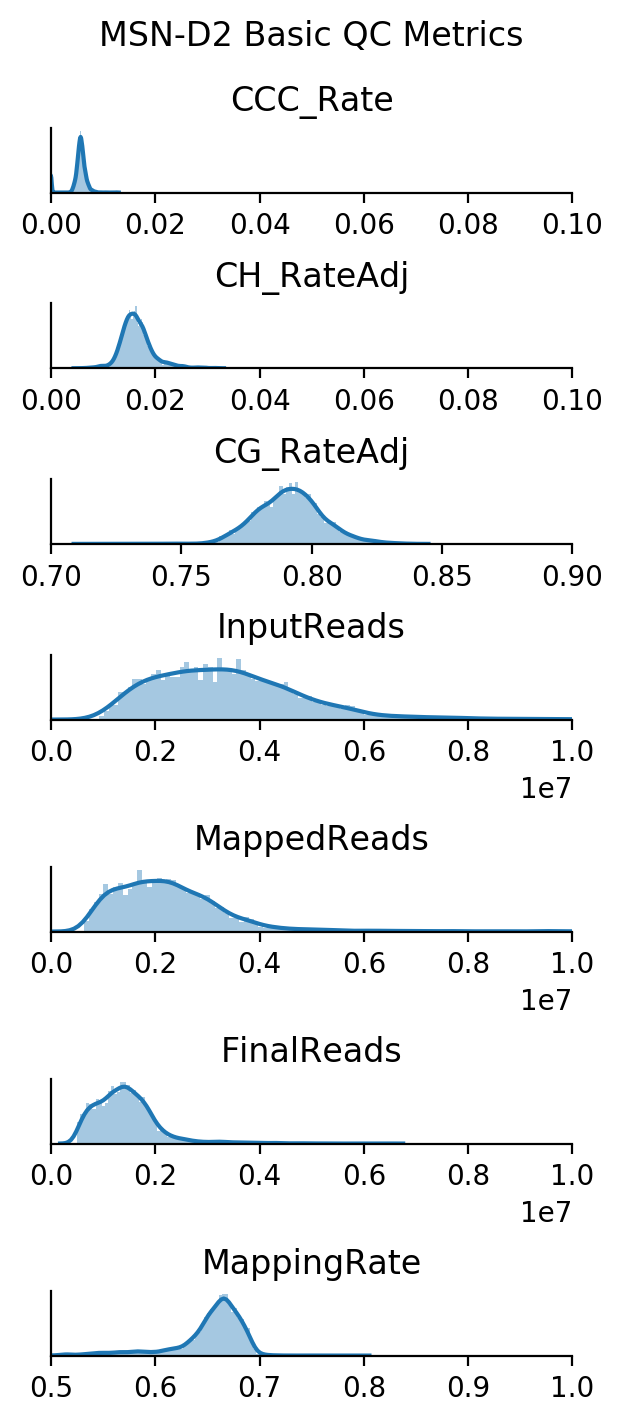

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

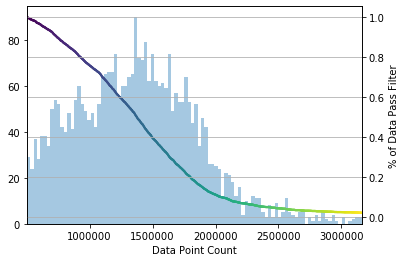

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 3340/3340 (100.0%)
CG_RateAdj passed 3340/3340 (100.0%)
CH_RateAdj passed 3340/3340 (100.0%)
FinalReads passed 3340/3340 (100.0%)
MappingRate passed 3340/3340 (100.0%)
Overall passed 3340/3340 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171207 1
171214 381
171219 490
180109 194
180110 226
180111 115
180119 5
180220 16
180222 24
180305 1
180320 19
180326 6
180329 38
180402 32
180403 6
180405 196
180417 2
180419 1
180529 1
180724 5
180806 21
180911 51
180917 8
180925 466
181008 1
181009 4
181015 104
181016 120
181204 9
181206 358
181210 1
181218 181
181220 254
190207 2
190214 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 440 114.6%
ad002 379 98.7%
ad004 415 108.1%
ad006 416 108.3%
ad007 388 101.0%
ad008 439 114.3%
ad010 446 116.1%
ad012 417 108.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
11E_M_1034,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.004962,0.793499,0.792469,0.019191,0.014299,1085453.0,2346706,1613664.0,11E,...,13.511821,1.843722,8.609268,-37.590920,MSN-D2,4.444021,-6.457721,15.188265,23.904722,True
1B_M_1027,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006040,0.784540,0.783230,0.018530,0.012570,751555.0,1559168,1004773.0,1B,...,15.970951,1.943978,3.568580,-38.998692,MSN-D2,7.857659,-7.506260,32.221070,27.237163,True
1B_M_1222,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006200,0.792310,0.791010,0.019970,0.013860,552337.0,1315994,789834.0,1B,...,14.890099,0.975357,3.966445,-37.599703,MSN-D2,6.985902,-7.677952,38.719784,16.744447,True
1B_M_176,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006680,0.794800,0.793420,0.022490,0.015920,1085592.0,2263042,1512495.0,1B,...,16.841385,3.313618,0.315568,-42.517516,MSN-D2,8.619150,-8.210255,37.043656,35.028098,True
1B_M_487,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006640,0.800320,0.798990,0.021620,0.015080,2303841.0,5391824,3499823.0,1B,...,16.058893,2.718807,3.377310,-42.167534,MSN-D2,8.274459,-7.660524,34.165717,26.317586,True
1B_M_665,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.007350,0.802130,0.800660,0.026790,0.019580,1365631.0,3227694,2128615.0,1B,...,15.382807,4.029618,5.908969,-46.706633,MSN-D2,7.404872,-10.481448,23.849201,46.567408,True
2B_M_336,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.005710,0.807460,0.806350,0.021710,0.016090,982401.0,2497980,1582359.0,2B,...,15.584169,2.816857,6.568691,-43.803874,MSN-D2,7.359369,-8.751529,23.191401,39.365989,True
2D_M_1200,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.004530,0.802540,0.801640,0.018730,0.014260,1005110.0,2299050,1525946.0,2D,...,15.497302,2.537130,3.429794,-41.606221,MSN-D2,6.230915,-7.246639,17.517652,33.524602,True
2D_M_1875,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.004310,0.802830,0.801980,0.020070,0.015830,1803040.0,4227644,2785311.0,2D,...,15.011471,3.867755,5.769734,-48.085871,MSN-D2,5.233068,-8.051099,15.681268,35.563842,True
